## Natural Language Processing with Disaster Tweets

### Introduction

- The purpose of this notebook is to evaluate the provided Tweeter data and develop a NLP model to predict which Tweets are referring to real disasters.
- A different approach from that used in the starter notebook provided, which uses the DistilBERT model, will be used to try to improve on the starter notebook results. Two approaches will be used: Topic Modeling and Gated Recurrent Unit (GRU)

### Imports

- Library Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk

# download nltk stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, TextVectorization

from scipy.stats import uniform

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


Using TensorFlow backend


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuelportillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Import Data

In [2]:
path = '/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/module4/kaggle_nlp_data/nlp-getting-started'

train_df = pd.read_csv(f'{path}/train.csv')
test_df = pd.read_csv(f'{path}/test.csv')
sample_df = pd.read_csv(f'{path}/sample_submission.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# summarize the training data
def summary_info(df):
    print("INFO")
    display(df.info());
    print('\n')
    print("Summary information")
    display(df.describe())
    print('\n')
    print("Null Values")
    null_values = df.isnull().sum()/df.shape[0]
    display(null_values[null_values >0])
    print('\n')
    print('Duplicate Articles')
    display(df.duplicated().sum())

summary_info(train_df)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None



Summary information


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000




Null Values


keyword     0.008013
location    0.332720
dtype: float64



Duplicate Articles


np.int64(0)

### EDA

- Train data distribution

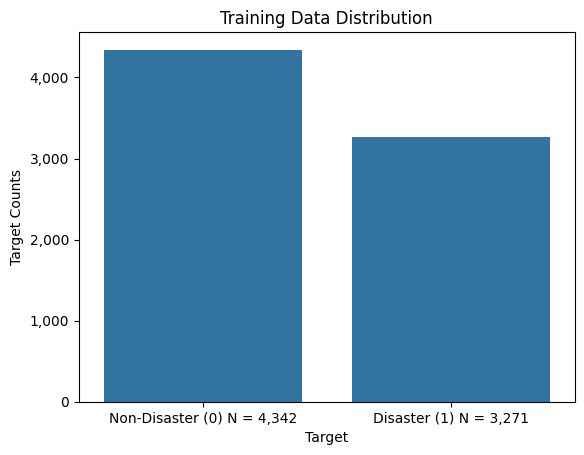

In [5]:
order_values = train_df['target'].value_counts().index
ax = sns.countplot(train_df, x='target', order = order_values)
plt.xlabel('Target')
plt.ylabel('Target Counts')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Training Data Distribution')
plt.xticks(ticks=[0, 1], labels=[f"Non-Disaster (0) N = {train_df['target'].value_counts()[0]:,}", 
                                 f"Disaster (1) N = {train_df['target'].value_counts()[1]:,}"]); 

- Distribution of word and character counts 

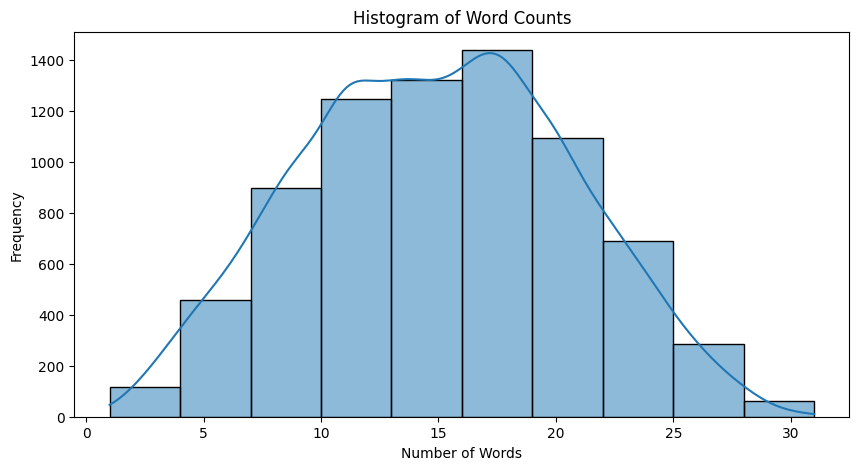

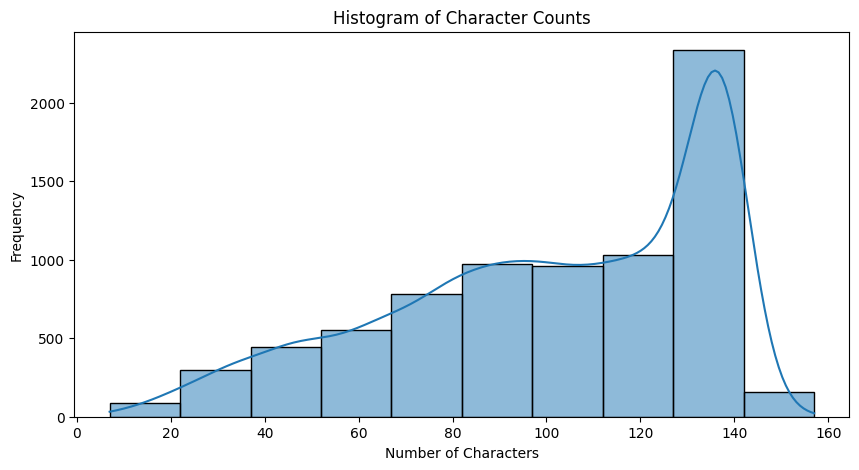

In [6]:
# check word count in text
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))

#Histogram of word counts
plt.figure(figsize = (10,5));
sns.histplot(train_df['word_count'],bins = 10,kde = True);
plt.title('Histogram of Word Counts');
plt.xlabel('Number of Words');
plt.ylabel('Frequency');


#Histogram of Character Counts
plt.figure(figsize = (10,5));
sns.histplot(train_df['char_count'], bins = 10,kde = True);
plt.title('Histogram of Character Counts');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');


In [7]:
#Average and mean lengths per category
length_stats = train_df.groupby('target').agg(
    avg_words = ('word_count', 'mean'),
    median_words = ("word_count", 'median'),
    avg_chars = ('char_count', 'mean'),
    median_chars = ('char_count', 'median')
).round(2)

length_stats

,avg_words,median_words,avg_chars,median_chars
target,,,,
0,14.70,15.0,95.71,101.0
1,15.17,15.0,108.11,115.0


- The summary shows that disaster tweets are slightly longer than the non-disaster tweets

- Most common words in tweets

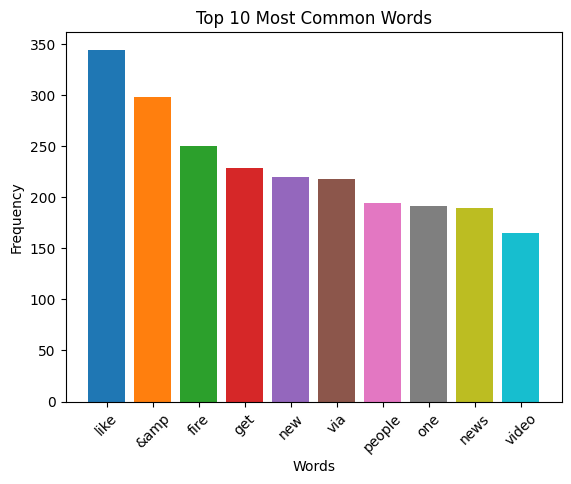

In [8]:
stop_words = set(stopwords.words('english'))

# function to tokenize and remove stopwords
def tokenize_text(text):
    words = str(text).lower().split()
    words = [w.strip('.,!?;:()[]-"\'%#') for w in words]
    return [w for w in words  if w not in stop_words and w != '']
    
# Most common words 
all_words = []
train_df['text'].apply(lambda x: all_words.extend(tokenize_text(x)))
overall_counts = Counter(all_words)
top10_words = dict(overall_counts.most_common(10))
for word, count in top10_words.items():
    plt.bar(word,count)
    plt.title("Top 10 Most Common Words")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation = 45);


- Most common words in non-disaster (0) vs. disaster (1) tweets

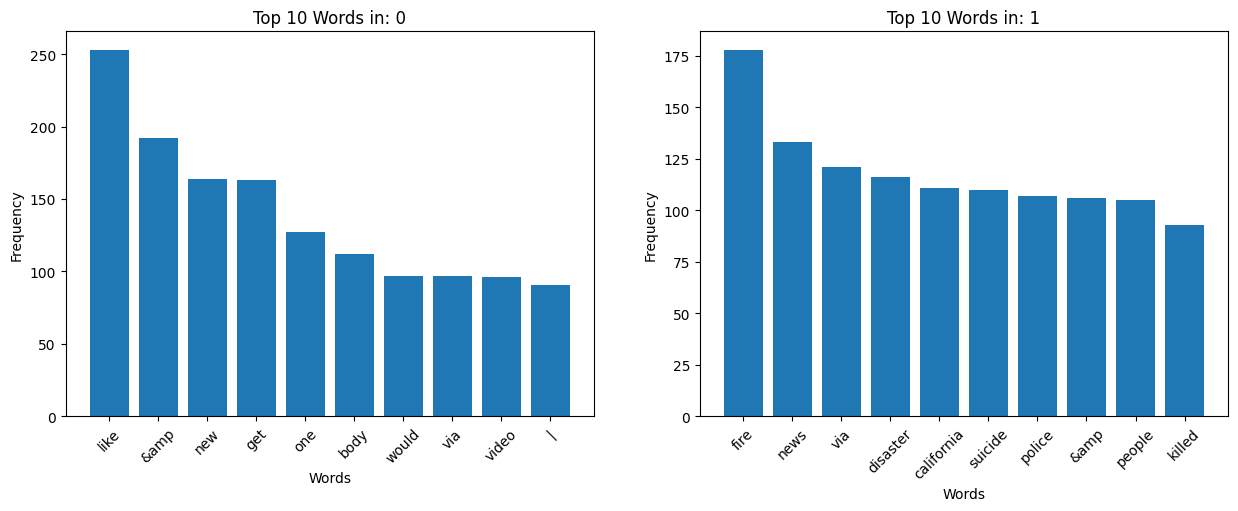

In [9]:
# Most common words and Vocabulary per category
vocab_per_category = {}
category_counts = {}
for cat, group in train_df.groupby('target'):
    words_cat = []
    group['text'].apply(lambda x: words_cat.extend(tokenize_text(x)))
    category_counts[cat] = Counter(words_cat).most_common(10)
    vocab_per_category[cat] = len(set(words_cat))
    
vocab = pd.DataFrame({
    'Category': list(vocab_per_category.keys()),
    'Vocabary_size': list(vocab_per_category.values())
})


fig, axes = plt.subplots(1,2,figsize = (15, 5))
axes = axes.flatten()

for ax, (cat, counts) in zip(axes, category_counts.items()):
    words,freq = zip(*counts)
    ax.bar(words, freq)
    ax.set_title(f'Top 10 Words in: {cat}')
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis = 'x', rotation = 45)


##### Fire and suicide appear to be the largest reason for disasters in these tweets - with a lot of these happening in California, likely mostly due to fires

In [10]:
# look at size of vocabulary used in types of tweets
vocab

,Category,Vocabary_size
0,0,14900
1,1,12043


- The higher number indicates a larger vocabulary or a more diverse word usage. For disaster tweets, a smaller vocabulary and higher word count indicates repeat use of words.

### Topic Modeling  
- Topic modeling will be used since we are trying to model two category topics: Disaster and Non-disaster

- Train/Validation split and Test data: a 80-20 split will be used for the training data
- The model performance will be evaluated on the validation data before scoring the test data for submission 

In [11]:
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['target'], random_state=42)
X_test = test_df['text']

- Will use topic modeling TF-IDF + Single Value Decomposition + Logistic Regression

In [12]:
# specify model pipeline and find best parameters to use
Pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    TruncatedSVD(random_state=42),
    LogisticRegression(max_iter=2000, random_state=42)
)

param_distributions = {
    'tfidfvectorizer__max_features': [5000, 10000, 15000],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2)],
    'tfidfvectorizer__min_df': [2, 3, 5],
    'tfidfvectorizer__max_df': [0.85, 0.9, 0.95],
    'truncatedsvd__n_components': [100, 150, 200],
    'logisticregression__C': uniform(0.1, 10),
}

Random_search = RandomizedSearchCV(
    Pipeline,
    param_distributions=param_distributions,
    n_iter=20,          # number of random combinations to try
    scoring='accuracy',
    cv=5,               # 5-fold cross-validation
    verbose=0,
    n_jobs=-1,
    random_state=42
)

Random_search.fit(train_data['text'], train_data['target'])
best_params = Random_search.best_params_
print("Best parameters:", best_params)
print("Best CV accuracy:", Random_search.best_score_)


/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/c312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'logisticregression__C': np.float64(4.597541333697656), 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__max_features': 10000, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 200}
Best CV accuracy: 0.7711001642036124


- Model Evaluation

In [13]:
# function to display confusion matrix 
def display_report(model, df):
    pred = model.predict(df['text'])
    print(classification_report(df['target'].astype(str), pred))
    cm = confusion_matrix(df['target'].astype(str),  pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=df['target'].astype(str).unique())
    disp.plot(xticks_rotation=45,cmap='Blues')
    plt.show()

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3473
           1       0.80      0.67      0.73      2617

    accuracy                           0.79      6090
   macro avg       0.79      0.77      0.78      6090
weighted avg       0.79      0.79      0.78      6090



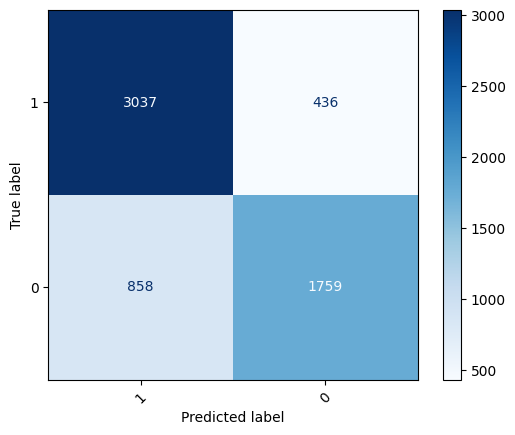

In [14]:
# results from using the best parameters found
Pipeline = make_pipeline(
    TfidfVectorizer(
        stop_words='english',
        max_features=best_params['tfidfvectorizer__max_features'],
        ngram_range=best_params['tfidfvectorizer__ngram_range'],
        min_df=best_params['tfidfvectorizer__min_df'],
        max_df=best_params['tfidfvectorizer__max_df']
    ),
    TruncatedSVD(
        n_components=best_params['truncatedsvd__n_components'],
        random_state=42
    ),
    LogisticRegression(
        max_iter=2000,
        C=best_params['logisticregression__C'],
        random_state=42
    )
)

Pipeline.fit(train_data['text'], train_data['target'].astype(str))
display_report(Pipeline, train_data)

In [15]:
# specify model used
model = Pipeline.fit(train_data['text'], train_data['target'].astype(str))

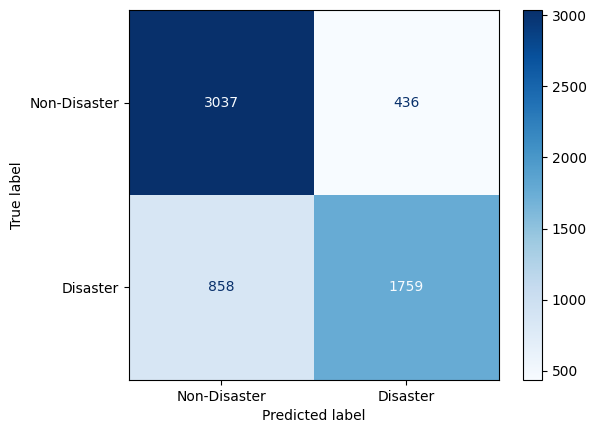

In [16]:
# score the training dataset to verify results above
y_pred_train = model.predict(train_data['text'])

disp = ConfusionMatrixDisplay.from_predictions(train_data['target'].astype(str)
                                               ,y_pred_train
                                               ,display_labels=["Non-Disaster", "Disaster"]
                                               ,cmap=plt.cm.Blues
                                               )


In [17]:
# training f1 score
tn, fp, fn, tp = confusion_matrix(train_data['target'].astype(str), y_pred_train).ravel()
f1_score_train = tp / (tp+((fn+fp)/2))
f1_score_train

np.float64(0.7310889443059019)

- Score validation data

np.float64(0.7383863080684596)

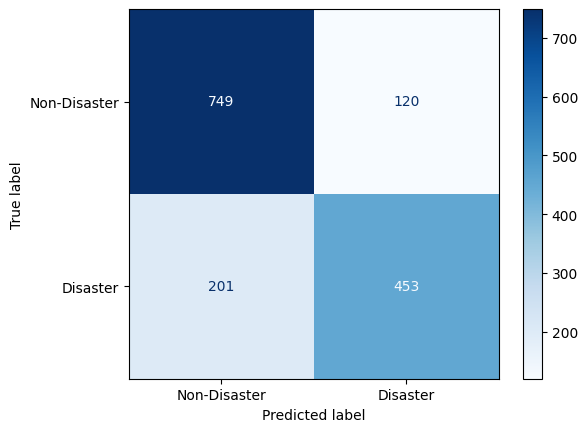

In [18]:
y_pred_val = model.predict(val_data['text'])

disp = ConfusionMatrixDisplay.from_predictions(val_data['target'].astype(str)
                                               ,y_pred_val
                                               ,display_labels=["Non-Disaster", "Disaster"]
                                               ,cmap=plt.cm.Blues
                                               )

tn, fp, fn, tp = confusion_matrix(val_data['target'].astype(str), y_pred_val).ravel()
f1_score_val = tp / (tp+((fn+fp)/2))
f1_score_val

- Score test data for submission

In [19]:
test_df['target'] = model.predict(test_df['text'])

In [20]:
test_df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [21]:
submission_df = test_df[['id', 'target']]
submission_df.head()

,id,target
0,0,1
1,2,0
2,3,0
3,9,0
4,11,1


In [22]:
submission_df.to_csv("submission.csv", index=False)

- Kaggle submission score for Topic model

<img src="mp_nlp_tweets_submission.png" alt="drawing" width="1200"/>


### GRU Model

In [23]:
# set-up model parameters
vocab_size = 10000 # we know from above that this is ~15k for non-disaster data
max_tweet_tokens = 40 # the model is sensitive to this value, if this is too large, the model will perform poorly
vectorizer = TextVectorization(
    max_tokens = vocab_size
    ,output_sequence_length = max_tweet_tokens
    ,output_mode = 'int'
)

vectorizer.adapt(train_df['text'].values)

- Train/Validatin split - using 80-20

In [24]:
text_vals = train_df['text'].values
target_vals = train_df['target'].values

X_train, X_val, y_train, y_val = train_test_split(text_vals, target_vals, test_size=0.2, random_state=42)

- Model Building

In [25]:
# specify model params
model = Sequential()
model.add(vectorizer)
model.add(Embedding(input_dim=vocab_size, output_dim=64))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model_hist = model.fit(X_train, y_train, epochs=8, batch_size=40, validation_data=(X_val, y_val))

Epoch 1/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5696 - loss: 0.6844 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 2/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.6841 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 3/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 4/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6833
Epoch 5/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.6845 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 6/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.6834 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 7/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6795 - loss: 0.5846 - val_accuracy: 0.7853 - val_loss: 0.4802
Epoch 8/8
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8631 - loss: 0.3494 - val_accuracy: 0.7925 - v

- Model Evaluation

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 40)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,221 (7.63 MB)

 Trainable params: 667,073 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,334,148 (5.09 MB)

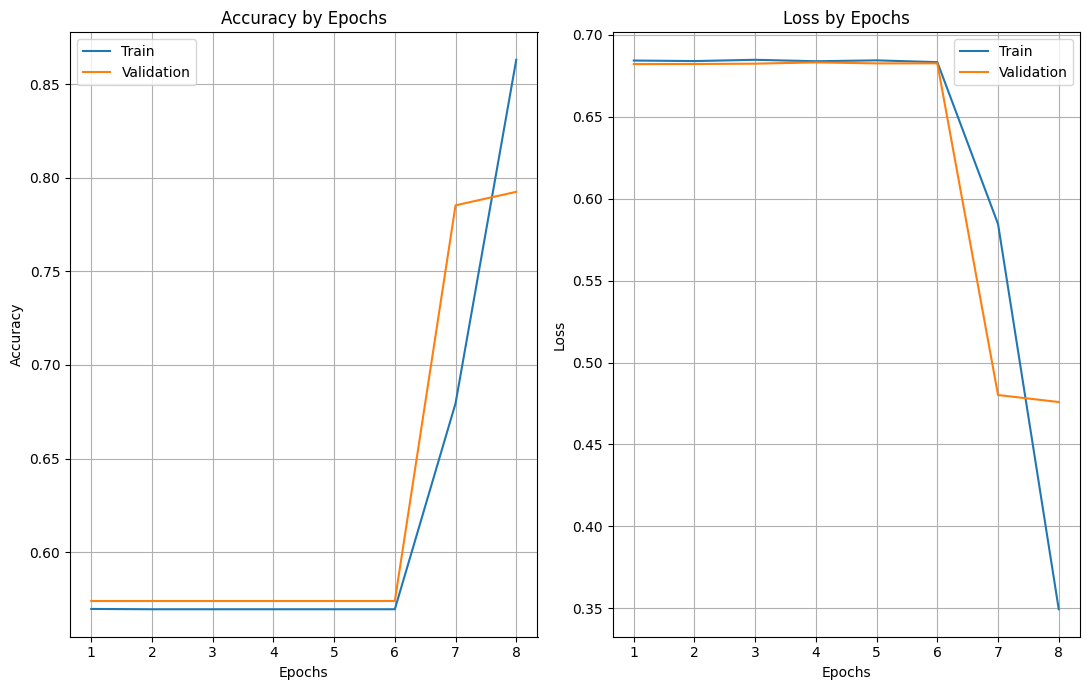

In [28]:
# plot the loss and accuracy across epochs
plt.figure(figsize=(11, 7))

# accuracy
epochs = range(1, len(model_hist.history['accuracy']) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, model_hist.history['accuracy'], label='Train')
plt.plot(epochs, model_hist.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epochs')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_hist.history['loss'], label='Train')
plt.plot(epochs, model_hist.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss by Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Score test data for submission

In [29]:
gru_test_preds = model.predict(test_df['text'].values)
gru_preds = (gru_test_preds > 0.5).astype(int).reshape(-1)

gru_submission_df = pd.DataFrame({'id': test_df['id'], 'target': gru_preds})
gru_submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<img src="gru_nlp_disaster_tweets.png" alt="drawing" width="1200"/>

### Conclusion

- The model trained using a Topic modeling approach performed reasonably well across all data samples
- The GRU model marginally outperforms the Topic model
- However, neither model performs better than the DistilBERT model in the starter notebook
- Approaches that can be explored to improve model performance are: test an updated version of the DistilBERT model, try a CNN model. However, as the data is not very large, these approaches may result in overfitting the data